<h1> Notebook utilising inital dataset</h1>
<p><i>Through my preentation, I discuss how after evaluating my model results, I found the model exceeded my expectations significantly. 
Upon looking at the dataset, I found some of the JPEG images had clear visual impairments in the 'forged' category, making it 
signficiantly easier for the model to detect fraud from original. This Notebook shows that inital dataset workflow. I use the alternaitve notebook to show how my models handle more detailed/high-definition images and impacts the overall model performance. As I discuss, my results in both notebooks follow similar trends regarding which models/techniques were more/less successful. I seperated the notebooks for readability and the workflow remains the same in both</i> </p>

In [ ]:
'''
Code base for COMP7710 *Note utilised tutorial code and
some AI generated code throughout assignment (AI was mostly
used for pre-processing, visualisation and correctly implementing class methods)
I will anotate where, why and explain the code :)
'''

#Step 1: imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


import os
import time


In [ ]:
#Utilises Google Drive for loading the data into notebook
# import files from google drive and unzip files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Uncomment if needing to remove and reset solution
#!rm -r COMP7710_FP_Dataset
# !rm -r COMP7710_FP_Dataset_2000/

In [ ]:
!cp /content/drive/MyDrive/COMP7710/COMP7710_FP_Dataset.zip ./

In [ ]:
#unzip my zip-file to be local in my Google Colab environment
!rm -rf './COMP7710_FP_Dataset'
!unzip '/content/COMP7710_FP_Dataset.zip'
# !rm -rf './ELA_Dataset'
data_dir = './COMP7710_FP_Dataset'

Streaming output truncated to the last 5000 lines.
  inflating: COMP7710_FP_Dataset/Original/2349.jpg  
  inflating: COMP7710_FP_Dataset/Original/235.jpg  
  inflating: COMP7710_FP_Dataset/Original/2350.jpg  
  inflating: COMP7710_FP_Dataset/Original/2351.jpg  
  inflating: COMP7710_FP_Dataset/Original/2352.jpg  
  inflating: COMP7710_FP_Dataset/Original/2353.jpg  
  inflating: COMP7710_FP_Dataset/Original/2354.jpg  
  inflating: COMP7710_FP_Dataset/Original/2355.jpg  
  inflating: COMP7710_FP_Dataset/Original/2356.jpg  
  inflating: COMP7710_FP_Dataset/Original/2357.jpg  
  inflating: COMP7710_FP_Dataset/Original/2358.jpg  
  inflating: COMP7710_FP_Dataset/Original/2359.jpg  
  inflating: COMP7710_FP_Dataset/Original/236.jpg  
  inflating: COMP7710_FP_Dataset/Original/2360.jpg  
  inflating: COMP7710_FP_Dataset/Original/2361.jpg  
  inflating: COMP7710_FP_Dataset/Original/2362.jpg  
  inflating: COMP7710_FP_Dataset/Original/2363.jpg  
  inflating: COMP7710_FP_Dataset/Original/2364.jpg

## **Pre-Processing Stage**

In [ ]:
#Apply ELA (Error Level Analysis) to images and generate new folder...
'''
*Note: This function involve in pre-processing utilised AI tools (Google Colab assistance)
       to help in the development process. It opens the original file,
       resaves file with 90% quality and then calculates difference
       between (the 'ELA' part), then saves the image to ELA directory...
'''

def apply_ela(image_path, output_path, quality=90):
    original = Image.open(image_path).convert('RGB')
    temp_path = image_path + '.resaved.jpg'
    original.save(temp_path, 'JPEG', quality=quality)
    resaved = Image.open(temp_path)

    ela_image = ImageChops.difference(original, resaved)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1.0
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    ela_image.save(output_path)
    os.remove(temp_path)

In [8]:
 # Generating new dataset with ELA applied (AI Assistance for utilising os module for saving/resaving images)
def process_dataset(input_dir, output_dir):
    for label in ['Original', 'Forged']:
        in_path = os.path.join(input_dir, label)
        out_path = os.path.join(output_dir, label)
        for fname in  os.listdir(in_path):
            if fname.lower().endswith(('.jpg', '.jpeg')):
              apply_ela(os.path.join(in_path, fname), #Call to ELA function
              os.path.join(out_path, fname)) #Save new ELA image

process_dataset(data_dir, './ELA_Dataset')

*Check Length of ELA in Original & Forged Directory*

In [9]:

original_total = os.listdir('./ELA_Dataset/Original')

forged_total = os.listdir('./ELA_Dataset/Forged')

print(f'Original: {len(original_total)}')
print(f'Forged: {len(forged_total)}')

Original: 6475
Forged: 2379


In [10]:
original_total[0:50]

['3540.jpg',
 '877.jpg',
 '5729.jpg',
 '5746.jpg',
 '4095.jpg',
 '1965.jpg',
 '3873.JPG',
 '3280.JPG',
 '2470.jpg',
 '4557.JPG',
 '4627.JPG',
 '2121.jpg',
 '5770.jpg',
 '4015.jpg',
 '5676.JPG',
 '3370.JPG',
 '314.jpg',
 '358.jpg',
 '3736.JPG',
 '5349.JPG',
 '1706.jpg',
 '4788.JPG',
 '2859.jpg',
 '824.jpg',
 '2695.jpg',
 '3677.jpg',
 '296.jpg',
 '4410.jpg',
 '2139.jpg',
 '351.jpg',
 '685.jpg',
 '3555.JPG',
 '2713.jpg',
 '3167.jpg',
 '3146.jpg',
 '2113.jpg',
 '2491.jpg',
 '4212.jpg',
 '3722.jpg',
 '3772.JPG',
 '5626.JPG',
 '3689.jpg',
 '2147.jpg',
 '3462.jpg',
 '1353.jpg',
 '2793.jpg',
 '5955.jpg',
 '5423.JPG',
 '1220.jpg',
 '2240.jpg']

*View an ELA Image vs an original non-ELA Image*

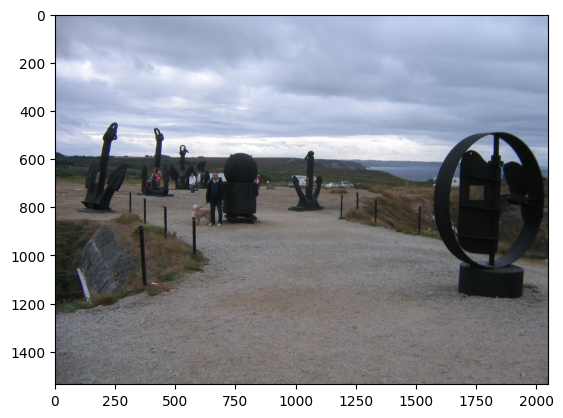

In [261]:
#View an Image with ELA not applied (original image)...
image = mpimg.imread('COMP7710_FP_Dataset/Original/'+original_total[12])

plt.imshow(image)
plt.show()

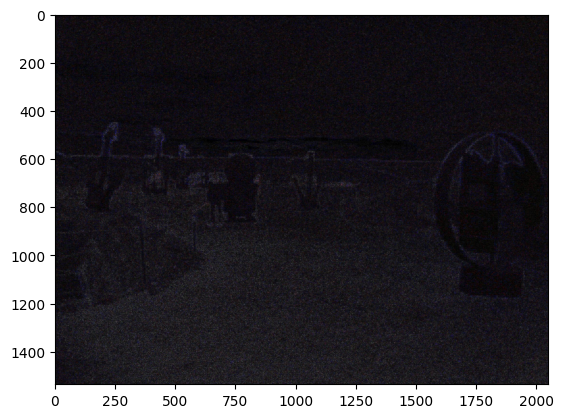

In [262]:
#View a image with ELA applied
image = mpimg.imread('ELA_Dataset/Original/' + original_total[12])

plt.imshow(image)
plt.show()

*Tampered/fraud Images with and without ELA

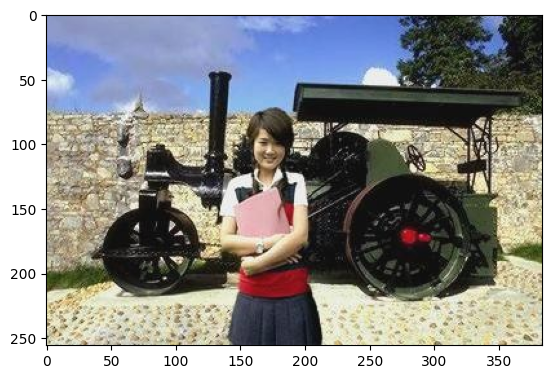

In [258]:
#Show orged/tampered image in non-ELA format

image = mpimg.imread('./COMP7710_FP_Dataset/Forged/'+forged_total[30])
plt.imshow(image)
plt.show()

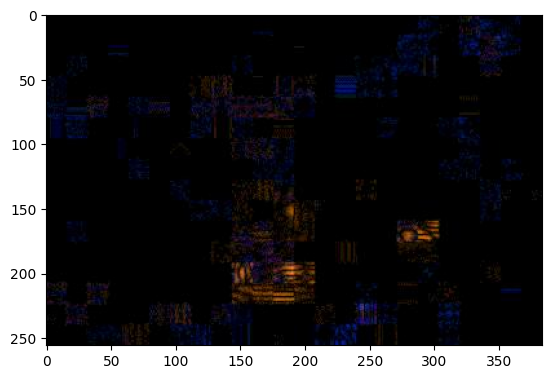

In [259]:
#Show fraud/tampered image in ELA format...
image = mpimg.imread('./ELA_Dataset/Forged/'+forged_total[30])
plt.imshow(image)
plt.show()

Note: Demonstrating same code as above but instead using CASIA 2.0 dataset. You will see the significant improvement
in quality of images (alternaitve notebook)

*Take only 2000 original and tampered images to be used in ML models*

In [13]:
#ELA path
dataset_path="ELA_Dataset/"
path_original_images = 'Original/'
path_tampered_images = 'Forged/'

total_original = os.listdir(dataset_path+path_original_images)[0:2000]
total_tampered = os.listdir(dataset_path+path_tampered_images)[0:2000]
print(f'Length of original images used in model is: {len(total_original)} and length of tampered is {len(total_tampered)}')

Length of original images used in model is: 2000 and length of tampered is 2000


*Convert the images and labels into a format to store in numpy array...*

In [14]:
#Label for supervised learning algorithms, this will be used as 'Y' in train_test phase
#Note* This is DIFFERENT for when CNN is applied (image folder pre-decides labels)
original_label = [0] * len(total_original)
tampered_label = [1] * len(total_tampered)

In [15]:
#Helper function to convert Image to flattened numpy array (AI assistance)
from PIL import Image

def process_image(image_path, size=(128, 128), quality=90):
    # Open and resize image
    ela_image = Image.open(image_path).convert('RGB')
    ela_image = ela_image.resize(size)

    # Convert ELA image to flattened NumPy array
    ela_array = np.array(ela_image)             # Shape: (128, 128, 3)
    flattened = ela_array.flatten()             # Shape: (128*128*3,) â†’ (49,152,)

    return flattened

In [16]:
features = process_image(dataset_path+path_original_images+total_original[0])
print(features.shape)  # Output: (49152,)

(49152,)


In [17]:
X = []
#Array of x features (should be 128 * 128 * 3 features for each image)
for image in total_original:
    features = process_image(dataset_path+path_original_images+image)
    X.append(features)
print("Flattened all original images")
for image in total_tampered:
    features = process_image(dataset_path+path_tampered_images+image)
    X.append(features)
print("Falttened all tampered images")
X = np.array(X)
print(f"Shape of X is {X.shape}")

Flattened all original images
Falttened all tampered images
Shape of X is (4000, 49152)


In [18]:
#Array of Y labels
y = original_label + tampered_label
y = np.array(y)

print(f"Shape of y (labels) is {y.shape}")

Shape of y (labels) is (4000,)


In [19]:
print(f"Any nulls in X...{np.isnan(X).any()}")
print(f"Any nulls in y...{np.isnan(y).any()}")

Any nulls in X...False
Any nulls in y...False


In [20]:
print(f"Datatype of X...{X.dtype}")
print(f"Datatype of y...{y.dtype}")

Datatype of X...uint8
Datatype of y...int64


## **Splitting into train-test split**
*Used for training and testing within the model*

In [21]:
from sklearn.model_selection import train_test_split

#Will use a train/test split of 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape[0], "samples in training set")
print(X_test.shape[0], "samples in test set")

3200 samples in training set
800 samples in test set


## **Logistic Regression (default)**
*Logistic regression model with default hyper params*

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

model_results = {}

''''
Function for testing models using relevant metrics...
(Utilises Tutorial 7 code as base)
'''

def get_model_results(model,X_train,X_test,y_train,y_test):
    #Fit logisitc regression with train data and print train accuracy
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    results = {
        "fit_time": end - start,
        "training_accuracy": model.score(X_train, y_train)*100,
        "cv_accuracy": cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean() * 100,
        "testing_accuracy": accuracy_score(y_test, y_pred)*100,
        "testing_precision": precision_score(y_test, y_pred)*100,
        "testing_recall": recall_score(y_test, y_pred)*100,
        "f1_score": f1_score(y_test, y_pred)*100,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print(f'time taken for fitting: {results["fit_time"]}')
    print(f'Training accuracy: {results["training_accuracy"]}')
    print(f'Average accuracy of cross_val_score: {results["cv_accuracy"]}\n')

    #Get test accuracy, precision and recall
    print("Testing accuracy: ", results['testing_accuracy'])
    print(f'Testing Precision: {results["testing_precision"]}')
    print(f'Testing Recall: {results["testing_recall"]}')
    print(f'f1 Score: {results["f1_score"]}')

    return results

In [30]:
from sklearn.linear_model import LogisticRegression

default_lr_model = LogisticRegression()

default_lr_model_results = get_model_results(default_lr_model, X_train, X_test, y_train, y_test)

time taken for fitting: 22.274911165237427
Training accuracy: 100.0
Average accuracy of cross_val_score: 97.4375

Testing accuracy:  97.625
Testing Precision: 98.9100817438692
Testing Recall: 96.03174603174604
f1 Score: 97.4496644295302


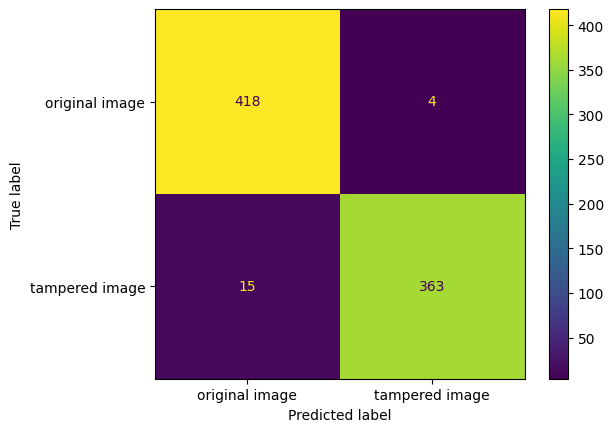

In [ ]:
#Print Confusion matrix for default model
model_results['logistic_regression_default'] = default_lr_model_results
ConfusionMatrixDisplay(default_lr_model_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

*Logistic Regression with scaled data...*

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
logistic_regression_scaled = LogisticRegression()

logistic_regression_scaled_results = get_model_results(logistic_regression_scaled, X_train_scaled, X_test_scaled, y_train, y_test)

model_results = {'logistic_regression_scaled': logistic_regression_scaled_results}

time taken for fitting: 7.493511199951172
Training accuracy: 100.0
Average accuracy of cross_val_score: 97.24999999999999

Testing accuracy:  97.875
Testing Precision: 99.45205479452055
Testing Recall: 96.03174603174604
f1 Score: 97.71197846567968


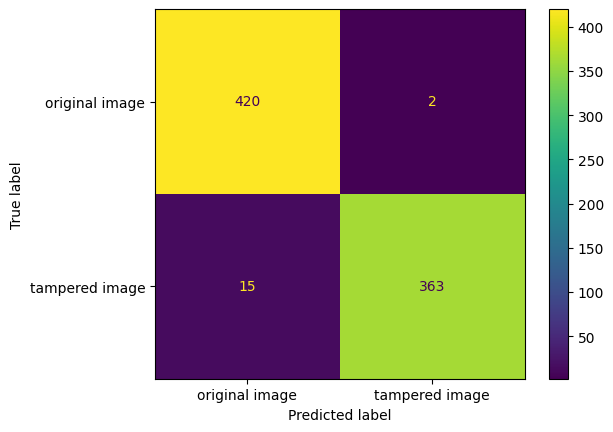

In [34]:
ConfusionMatrixDisplay(logistic_regression_scaled_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

# **LDA & PCA Analysis**
*generating both an LDA and PCA version of the dataset and then applying logistic regression & SVM...*

*Generate an dimension reduced version of X using LDA and view shape*

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#Reduce feature space with LDA...
lda_model = LDA()

lda_model.fit(X_train, y_train)

#Generate train and test datasets
X_train_lda = lda_model.transform(X_train)

X_test_lda = lda_model.transform(X_test)

In [36]:
X_train_lda.shape

(3200, 1)

*Dimensionaly reduce X using PCA and view shape*

In [37]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=0.95)

pca_model.fit(X_train)
print(pca_model.explained_variance_ratio_)

[2.23137267e-01 4.74947580e-02 2.21832734e-02 ... 8.74450525e-05
 8.74311641e-05 8.73291451e-05]


In [38]:
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)
print(f"Shape of X train pca: {X_train_pca.shape}")

Shape of X train pca: (3200, 2084)


*View cumulative explain variance of PCA with graph...*

Text(0, 0.5, 'cumulative explained variance')

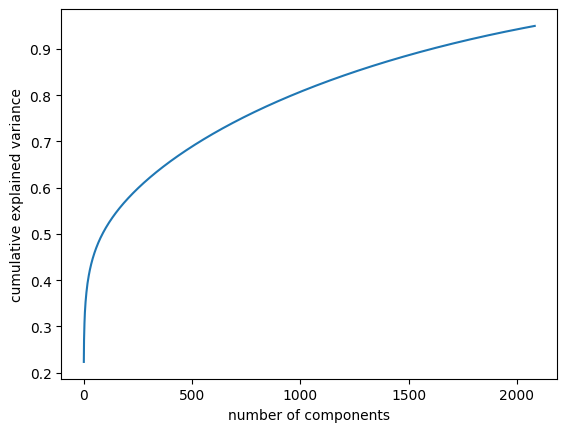

In [39]:
#Found useful graphing function on stack-overflow
# https://stackoverflow.com/questions/53802098/how-to-choose-the-number-of-components-pca-scikitliear
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

*View training and testing success of standard logistic regression with PCA and LDA*

*LDA results...*

In [40]:
logistic_regression_lda = LogisticRegression()

logistic_regression_lda_results = get_model_results(logistic_regression_lda, X_train_lda, X_test_lda, y_train, y_test)

model_results['logistic_regression_lda'] = logistic_regression_lda_results

time taken for fitting: 0.011247634887695312
Training accuracy: 98.40625
Average accuracy of cross_val_score: 98.375

Testing accuracy:  95.875
Testing Precision: 96.0
Testing Recall: 95.23809523809523
f1 Score: 95.61752988047809


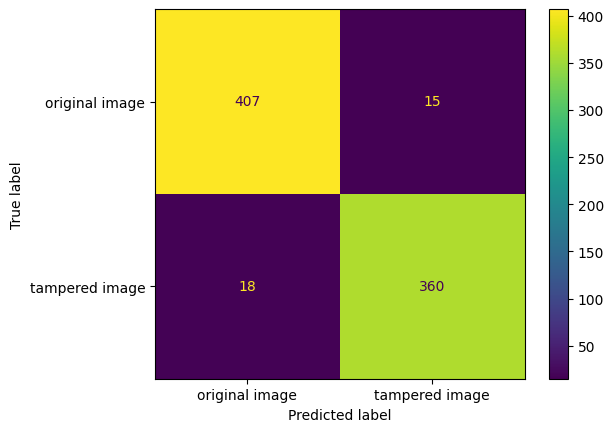

In [41]:
ConfusionMatrixDisplay(logistic_regression_lda_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

*PCA Results...*

In [42]:
logistic_regression_pca = LogisticRegression()

logistic_regression_pca_results = get_model_results(logistic_regression_pca, X_train_pca, X_test_pca, y_train, y_test)

model_results['logistic_regression_pca'] = logistic_regression_pca_results

time taken for fitting: 1.8030617237091064
Training accuracy: 100.0
Average accuracy of cross_val_score: 96.81249999999999

Testing accuracy:  97.375
Testing Precision: 98.9041095890411
Testing Recall: 95.5026455026455
f1 Score: 97.1736204576043


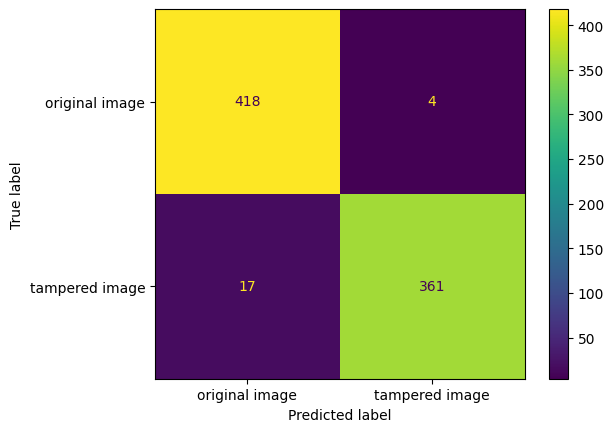

In [43]:
ConfusionMatrixDisplay(logistic_regression_pca_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

Handling overfitting of training accuracy on PCA...

*Reducing PCA components and and seeing how it impacts model...*

In [44]:
pca_model_2 = PCA(n_components=1000)


X_train_pca_1000 = pca_model_2.fit_transform(X_train)
X_test_pca_1000 = pca_model_2.transform(X_test)

logistic_regression_pca_1000 = LogisticRegression(max_iter = 3000)

logistic_regression_pca_1000_results = get_model_results(logistic_regression_pca_1000, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['logistic_regression_pca_1000'] = logistic_regression_pca_1000_results


time taken for fitting: 1.9655122756958008
Training accuracy: 100.0
Average accuracy of cross_val_score: 96.96875

Testing accuracy:  97.25
Testing Precision: 98.36956521739131
Testing Recall: 95.76719576719577
f1 Score: 97.05093833780161


*Finding maximum value of c for LDA and PCA*

In [45]:

#c values to test
def find_c_hyperparam(x_train, y_train):
  c_values = [0.01, 0.1, 1, 10, 100, 1000] # Values of C to check...

  acc_c = []

  for c in c_values:
      lr_model = LogisticRegression(C=c, max_iter = 3000)
      #use cross validation to create train and validation sets out of 5 folds
      scores = cross_val_score(lr_model, x_train, y_train, cv=5, scoring='accuracy')
      acc_c.append(scores.mean())
  print("Best C: ", c_values[np.argmax(acc_c)])

  return c_values[np.argmax(acc_c)]

In [46]:
start = time.time()
find_c_hyperparam(X_train_lda, y_train)
end = time.time()
print(f'total time to find best c for lda: {end - start}')

Best C:  0.01
total time to find best c for lda: 0.2626767158508301


In [47]:
start = time.time()
find_c_hyperparam(X_train_pca_1000, y_train)
end = time.time()
print(f'total time to find best c for pca: {end - start}')

Best C:  1
total time to find best c for pca: 54.50340509414673


Testing results for maximised c value for LDA & PCA

In [48]:
print("LDA improved c value...")


model_lda = LogisticRegression(C=0.01)
res = get_model_results(model_lda, X_train_lda, X_test_lda, y_train, y_test)


LDA improved c value...
time taken for fitting: 0.004143238067626953
Training accuracy: 98.40625
Average accuracy of cross_val_score: 98.40625

Testing accuracy:  95.625
Testing Precision: 95.49071618037135
Testing Recall: 95.23809523809523
f1 Score: 95.36423841059603


In [49]:
print("PCA improved c value...")

model_pca = LogisticRegression(C=10)
res = get_model_results(model_pca, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

PCA improved c value...
time taken for fitting: 0.5434205532073975
Training accuracy: 100.0
Average accuracy of cross_val_score: 96.9375

Testing accuracy:  97.375
Testing Precision: 98.3739837398374
Testing Recall: 96.03174603174604
f1 Score: 97.18875502008032


*Using the speed of LDA to maximise parameters*

In [ ]:
from sklearn.model_selection import GridSearchCV
# Function for finding optimal hyper parameters
def optimise(model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    print("Best CV accuracy:", grid.best_score_)
    return grid.best_params_

In [ ]:
#Maximising parameters of LDA...

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # safest with both l1 and l2
    'max_iter': [3000]        # ensure convergence
}

lr_lda_maximised = LogisticRegression()

best_lda_lr_params = optimise(lr_lda_maximised, param_grid, X_train_lda, y_train)

print("Best params:", best_lda_lr_params)


Best CV accuracy: 0.9840625
Best params: {'C': 0.001, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}


In [52]:
print("LDA Logistic Regression maximised...")


model_lda = LogisticRegression(C=0.01, max_iter=3000, penalty='l1', solver='liblinear')

logistic_regression_lda_maximised_results = get_model_results(model_lda, X_train_lda, X_test_lda, y_train, y_test)

model_results['logistic_regression_lda_maximised'] = logistic_regression_lda_maximised_results



LDA Logistic Regression maximised...
time taken for fitting: 0.0035772323608398438
Training accuracy: 98.40625
Average accuracy of cross_val_score: 98.40625

Testing accuracy:  95.625
Testing Precision: 94.7780678851175
Testing Recall: 96.03174603174604
f1 Score: 95.40078843626807


LDA results with maximising hyperparams...


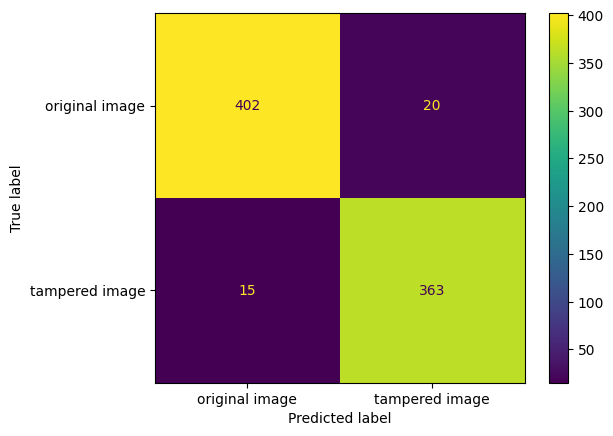

In [54]:
print("LDA results with maximising hyperparams...")
ConfusionMatrixDisplay(logistic_regression_lda_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

Maximise parameters for PCA

In [55]:
#Maximising parameters of PCA...
from sklearn.model_selection import GridSearchCV

#Utilised sklearn docs & GeeksForGeeks docs...
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # safest with both l1 and l2
    'max_iter': [3000]        # ensure convergence
}

lr_pca_maximised = LogisticRegression()

best_pca_lr_params = optimise(lr_pca_maximised, param_grid, X_train_pca_1000, y_train)

print("Best params:", best_pca_lr_params)

Best CV accuracy: 0.9665624999999999
Best params: {'C': 0.001, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'liblinear'}


In [56]:
print("PCA Logistic Regression maximised...")


model_pca = LogisticRegression(C=0.001, max_iter=3000, penalty='l1', solver='liblinear')

logistic_regression_pca_maximised_results = get_model_results(model_pca, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['logistic_regression_pca_maximised'] = logistic_regression_pca_maximised_results


PCA Logistic Regression maximised...
time taken for fitting: 0.310624361038208
Training accuracy: 97.375
Average accuracy of cross_val_score: 96.25

Testing accuracy:  96.5
Testing Precision: 96.79144385026738
Testing Recall: 95.76719576719577
f1 Score: 96.27659574468085


PCA results with maximising hyperparams...


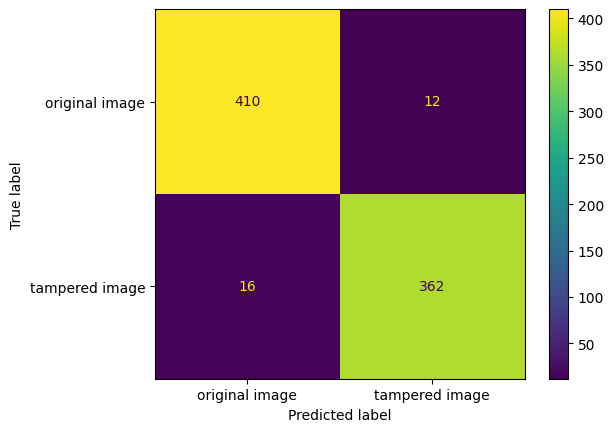

In [58]:
print("PCA results with maximising hyperparams...")
ConfusionMatrixDisplay(logistic_regression_pca_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

## **SVM Models**
*Applying linear & non-linear SVM with PCA & LDA feature reduction dataset *

In [59]:
from sklearn.svm import SVC


*Testing Linear kernel with LDA and PCA (default parameters)*

In [60]:
print("Linear kernel with LDA...")
svc = SVC(kernel='linear')
svc_linear_lda_results = get_model_results(svc, X_train_lda, X_test_lda, y_train, y_test)

model_results['svc_linear_lda'] = svc_linear_lda_results

Linear kernel with LDA...
time taken for fitting: 0.12273192405700684
Training accuracy: 98.4375
Average accuracy of cross_val_score: 98.46875

Testing accuracy:  96.125
Testing Precision: 96.7654986522911
Testing Recall: 94.97354497354497
f1 Score: 95.86114819759679


In [61]:
print("Linear kernel with PCA...")

svc_linear_pca_results = get_model_results(svc, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['svc_linear_pca'] = svc_linear_pca_results

Linear kernel with PCA...
time taken for fitting: 1.5048112869262695
Training accuracy: 100.0
Average accuracy of cross_val_score: 96.46874999999999

Testing accuracy:  97.5
Testing Precision: 98.90710382513662
Testing Recall: 95.76719576719577
f1 Score: 97.31182795698925


*Hyper-parameter tuning for SVC with LDA dataset*

In [62]:
#Finding optimal kernel for LDA dataset...

param_grid = {
    "kernel": ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = SVC()
best_kernel = optimise(svc, param_grid, X_train_lda, y_train)['kernel']
best_kernel


Best CV accuracy: 0.9846875


'linear'

In [63]:
#Find best c value with optimal kernel...
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

svc = SVC(kernel = best_kernel)
best_c = optimise(svc, param_grid, X_train_lda, y_train)['C']
best_c

Best CV accuracy: 0.9846875


0.01

In [64]:
#find best degree value with optimal "C" and Kernel...
param_grid = {
    "degree": list(range(2,10,1))
}

svc = SVC(kernel = best_kernel, C = best_c)

best_degree = optimise(svc, param_grid, X_train_lda, y_train)['degree']
best_degree

Best CV accuracy: 0.9846875


2

In [65]:
#Evaluate SVC with optimised parameters using LDA dataset
svc = SVC(kernel=best_kernel, C=best_c, degree=best_degree)
svc_lda_maximised_results = get_model_results(svc, X_train_lda, X_test_lda, y_train, y_test)

model_results['svc_lda_maximised'] = svc_lda_maximised_results

time taken for fitting: 0.09115004539489746
Training accuracy: 98.46875
Average accuracy of cross_val_score: 98.46875

Testing accuracy:  96.25
Testing Precision: 97.28260869565217
Testing Recall: 94.70899470899471
f1 Score: 95.97855227882037


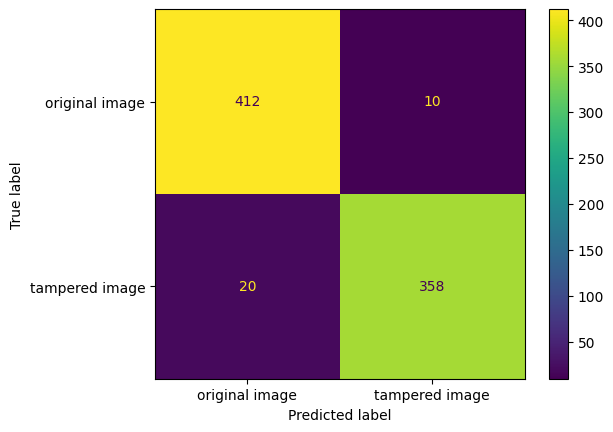

In [66]:
ConfusionMatrixDisplay(svc_lda_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

*Hyper-parameter tuning for SVC with PCA dataset (same process as above)*

In [ ]:
#Optimising PCA dataset with alternate kernel

param_grid = {
    "kernel": ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = SVC()
best_kernel_pca = optimise(svc, param_grid, X_train_pca_1000, y_train)['kernel']
best_kernel_pca

Best CV accuracy: 0.9721875000000001


'rbf'

In [68]:
#Find best c value with optimal kernel...
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

svc = SVC(kernel = best_kernel_pca)
best_c_pca = optimise(svc, param_grid, X_train_pca_1000, y_train)['C']
best_c_pca

Best CV accuracy: 0.9824999999999999


10

In [69]:
#find best degree value with optimal "C" and Kernel...
param_grid = {
    "degree": list(range(2,10,1))
}

svc = SVC(kernel = best_kernel_pca, C = best_c_pca)

best_degree_pca = optimise(svc, param_grid, X_train_pca_1000, y_train)['degree']
best_degree_pca

Best CV accuracy: 0.9824999999999999


2

In [ ]:
#Evaluate SVC with optimised parameters using PCA dataset
svc = SVC(kernel=best_kernel_pca, C=best_c_pca, degree=best_degree_pca)
svc_pca_maximised_results = get_model_results(svc, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['svc_pca_maximised'] = svc_pca_maximised_results

time taken for fitting: 2.709587812423706
Training accuracy: 100.0
Average accuracy of cross_val_score: 98.25

Testing accuracy:  98.25
Testing Precision: 99.72677595628416
Testing Recall: 96.56084656084656
f1 Score: 98.11827956989248


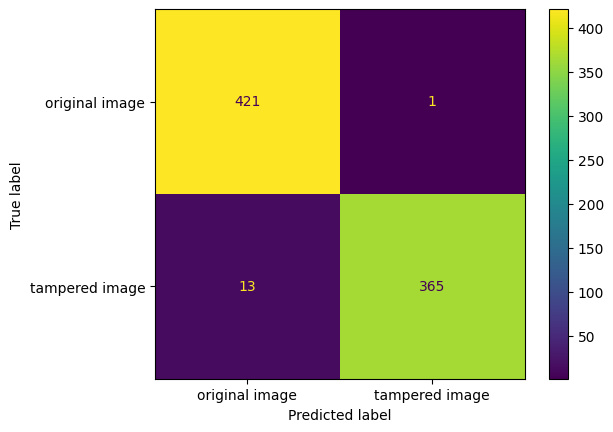

In [71]:
ConfusionMatrixDisplay(svc_pca_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

# **CNN Model**

In [143]:
# transform data for pre-normalisation step

# Transform without normalization (for mean/std)
'''
Note: A large portion of code for CNN transformation
      and development was taken from tutorial with slight
      modification to hyper-parameters to better fit/model
      data
'''
temp_transform = transforms.Compose([
    transforms.Grayscale(),
      transforms.RandomRotation(5, fill=(0,)), # Data augmentation
    transforms.RandomCrop(128, padding=2),    # Data augmentation
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [144]:
#ImageFolder is a class in pytorch used for loading image data
#That is sorted in folder format (./Forged, ./Original) representing
#their class
dataset = datasets.ImageFolder('ELA_Dataset/', transform=temp_transform)

In [145]:
#View image entry converted to tensor
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0431, 0.0314, 0.0275],
          [0.0000, 0.0000, 0.0157,  ..., 0.0235, 0.0392, 0.0510],
          [0.0000, 0.0000, 0.0196,  ..., 0.0039, 0.0275, 0.0392]]]),
 0)

In [146]:
# label 0 is Forged, label 1 is Original
print(dataset.class_to_idx)

{'Forged': 0, 'Original': 1}


In [147]:
# Generate train, val and test splits

# Manually select 2000 jpeg/jpg samples from each class (AI Assistance)
original_indices = [i for i, (path, label) in enumerate(dataset.samples) if dataset.classes[label] == 'Original' and (path.lower().endswith('.jpg') or path.lower().endswith('.jpeg'))][:2000]
forged_indices = [i for i, (path, label) in enumerate(dataset.samples) if dataset.classes[label] == 'Forged' and (path.lower().endswith('.jpg') or path.lower().endswith('.jpeg'))][:2000]

# Combine the indices
subset_indices = original_indices + forged_indices

# Create a Subset of the dataset using the selected indices
subset_dataset = Subset(dataset, subset_indices)

print(f"length of of dataset...{len(subset_dataset)}")


length of of dataset...4000


In [148]:
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_set, test_set = random_split(subset_dataset, [train_size, test_size])
print(f"length of train set: {len(train_set)}")
print(f"length of test set: {len(test_set)}")

length of train set: 3200
length of test set: 800


In [149]:
val_percentage = 0.2

val_size = int(val_percentage * len(train_set))
train_size = len(train_set) - val_size

train_set, val_set = random_split(train_set, [train_size, val_size])

In [150]:
print(f"Length of train set: {len(train_set)}")
print(f"length of val set: {len(val_set)}")
print(f"length of test set: {len(test_set)}")

Length of train set: 2560
length of val set: 640
length of test set: 800


In [151]:
# Compute mean and std of training data
'''
Note: Function utilised AI assistance throughout development
'''
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch_samples

    mean /= total
    std /= total
    return mean, std

mean, std = compute_mean_std(train_set)

In [152]:
print('mean: ' + str(mean.tolist()[0]))
print('std: ' + str(std.tolist()[0]))

mean: 0.07579435408115387
std: 0.05901137739419937


In [ ]:
#Redefine with normalisation

'''
Tutorial code + minor AI assistance for finding helper classes/methods
From this point on, a large portion of code is taken from the tutorial and
modified with hyper-params
'''
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(5, fill=(0,)), # Data augmentation
    transforms.RandomCrop(128, padding=2),    # Data augmentation
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Apply to datasets
dataset.transform = train_transform
train_set.dataset.transform = train_transform
val_set.dataset.transform = train_transform
test_set.dataset.transform = train_transform

In [154]:
#Create interator through dataloaders
BATCH_SIZE = 64

train_iterator = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(val_set, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_set, batch_size=BATCH_SIZE)

In [155]:
#Creating neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LeNet(nn.Module):
    def __init__(self, output_dim=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,
                              out_channels=16,
                            kernel_size=5)


        self.fc1 = nn.Linear(16 * 29 * 29, 120) #For 128 bit image
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        # [batch_size, 1, 28, 28]
        x = self.conv1(x)

        # [batch_size, 6,24 ,24]
        x = F.max_pool2d(x, kernel_size=2)
        # [batch_size, 6, 12 ,12]

        x = F.relu(x)
        x = self.conv2(x)
        # [batch_size, 16, 8 ,8]

        x = F.max_pool2d(x, kernel_size=2)
        # [batch_size, 16, 4 ,4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        # [batch_size, 16* 4 * 4]

        x = self.fc1(x)

        x = F.relu(x)

        x = self.fc2(x)

        x = F.relu(x)

        x = self.fc3(x)


        return x

In [156]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [157]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,628,426 trainable parameters


## **Training the CNN model**

In [158]:
#Define the optimizer
optimizer = optim.Adam(model.parameters())

In [159]:
#Loss function...
criterion = nn.CrossEntropyLoss()

In [160]:
#Device on CPU or GPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [161]:
model = model.to(device)
criterion = criterion.to(device)

In [162]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [163]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss, epoch_acc = 0, 0

    model.train()

    for (item, label) in iterator:
        item, label = item.to(device), label.to(device)

        optimizer.zero_grad()

        y_pred = model(item)

        loss = criterion(y_pred, label)

        acc = calculate_accuracy(y_pred, label)

        loss.backward()
        optimizer.step()

        # log

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [164]:
def evaluate(model, iterator, criterion, device):

    epoch_loss, epoch_acc = 0, 0

    model.eval()

    with torch.no_grad():
        for (item, label) in iterator:
            item, label = item.to(device), label.to(device)

            y_pred = model(item)

            loss = criterion(y_pred, label)

            acc = calculate_accuracy(y_pred, label)


            # log

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [165]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [166]:
EPOCHS = 32

best_valid_loss = float('inf')

train_accs = []
valid_accs = []

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.704 | Train Acc: 61.68%
	 Val. Loss: 0.562 |  Val. Acc: 66.56%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.393 | Train Acc: 81.45%
	 Val. Loss: 0.269 |  Val. Acc: 90.62%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.224 | Train Acc: 90.43%
	 Val. Loss: 0.154 |  Val. Acc: 93.12%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 0.210 | Train Acc: 90.51%
	 Val. Loss: 0.197 |  Val. Acc: 91.09%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.222 | Train Acc: 90.66%
	 Val. Loss: 0.147 |  Val. Acc: 93.59%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.171 | Train Acc: 93.01%
	 Val. Loss: 0.165 |  Val. Acc: 92.19%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.156 | Train Acc: 93.12%
	 Val. Loss: 0.113 |  Val. Acc: 93.91%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.169 | Train Acc: 92.97%
	 Val. Loss: 0.119 |  Val. Acc: 93.91%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.152 | Train Acc: 93.98%
	 Val. Loss: 0.119 |  Val. Acc: 95.31%
Epoch: 10 | Epoch T

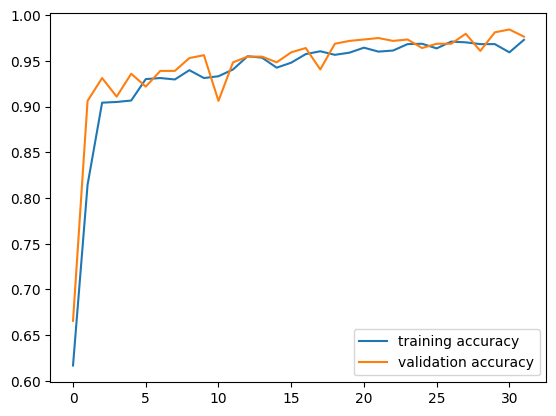

In [167]:
plt.plot(train_accs, label="training accuracy")
plt.plot(valid_accs, label = "validation accuracy")
plt.legend()
plt.show()


In [186]:

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.065 | Test Acc: 97.72%


In [ ]:
# Function to get relevant predictions of model
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
#Store the image, labels and probabilities of predictions
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [190]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(2));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    ax.xaxis.set_ticklabels(['forged', 'original']); ax.yaxis.set_ticklabels(['forged', 'original'])

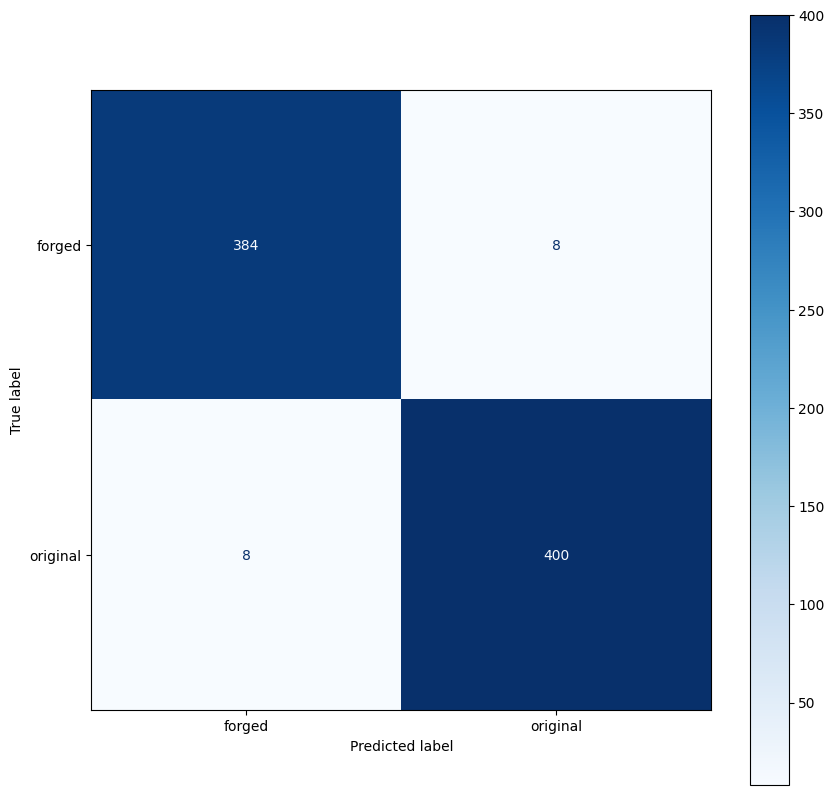

In [191]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
#Get correct predictions
corrects = torch.eq(labels, pred_labels)

In [ ]:
#Get incorrect predictions
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [194]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(128, 128).cpu().numpy(), cmap = 'bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

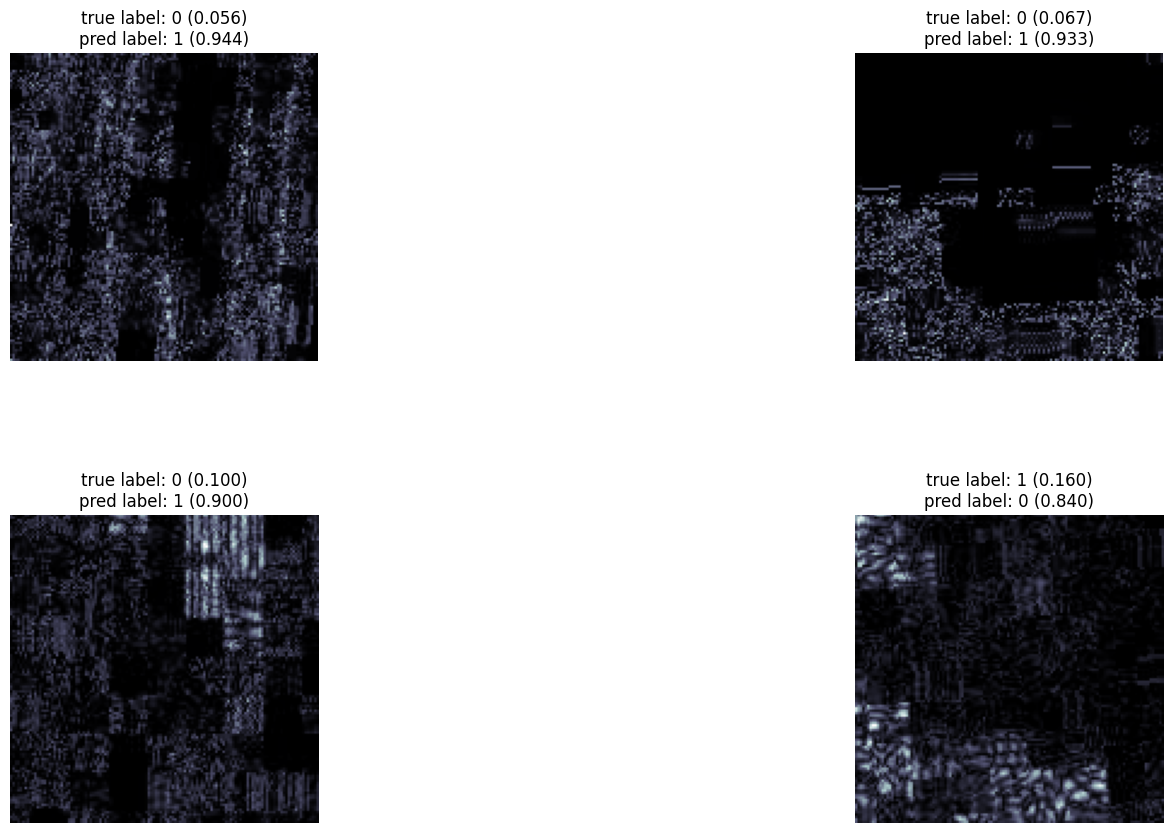

In [195]:
N_IMAGES = 4

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [207]:

precision = precision_score(labels, pred_labels)
recall = recall_score(labels, pred_labels)

cnn_f1_score = f1_score(labels, pred_labels)

print(f'Test Precision for CNN: {precision:.3f}')
print(f'Test Recall for CNN: {recall:.3f}')
print(f'Test F1 Score for CNN: {cnn_f1_score:.3f}')

Test Precision for CNN: 0.980
Test Recall for CNN: 0.980
Test F1 Score for CNN: 0.980


In [211]:
# Add CNN results to model_results dictionary
model_results['cnn_model'] = {
    "cv_accuracy": max(train_accs) * 100, # Using max training accuracy as CV different in CNN models...
    "testing_accuracy": test_acc * 100,
    "testing_precision": precision * 100,
    "testing_recall": recall * 100,
    "f1_score": cnn_f1_score * 100,
    "confusion_matrix": confusion_matrix(labels, pred_labels)
}

model_results['cnn_model']

{'cv_accuracy': 97.3046875,
 'testing_accuracy': 97.71634615384616,
 'testing_precision': 98.0392156862745,
 'testing_recall': 98.0392156862745,
 'f1_score': 98.0392156862745,
 'confusion_matrix': array([[384,   8],
        [  8, 400]])}

## **Comparison**
*Generating tables and graphs for comparison purposes...*


In [212]:
import pandas as pd
Data = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "Test Precission": [],
    "Test Recall": [],
    "Test F1 Score": []
}

for name in model_results.keys():
    Data["Model"].append(name)
    Data["Train Accuracy"].append(model_results[name]["cv_accuracy"])
    Data["Test Accuracy"].append(model_results[name]["testing_accuracy"])
    Data["Test Precission"].append(model_results[name]["testing_precision"])
    Data["Test Recall"].append(model_results[name]["testing_recall"])
    Data["Test F1 Score"].append(model_results[name]["f1_score"])

Data = pd.DataFrame(Data)
Data

Model  Train Accuracy  Test Accuracy  \
0          logistic_regression_scaled       97.250000      97.875000   
1             logistic_regression_lda       98.375000      95.875000   
2             logistic_regression_pca       96.812500      97.375000   
3        logistic_regression_pca_1000       96.968750      97.250000   
4   logistic_regression_lda_maximised       98.406250      95.625000   
5   logistic_regression_pca_maximised       96.250000      96.500000   
6                      svc_linear_lda       98.468750      96.125000   
7                      svc_linear_pca       96.468750      97.500000   
8                   svc_lda_maximised       98.468750      96.250000   
9                   svc_pca_maximised       98.250000      98.250000   
10                          cnn_model       97.304688      97.716346   

    Test Precission  Test Recall  Test F1 Score  
0         99.452055    96.031746      97.711978  
1         96.000000    95.238095      95.617530  
2         98.904110    95.502646      97.173620  
3         98.369565    95.767196      97.050938  
4         94.778068    96.031746      95.400788  
5         96.791444    95.767196      96.276596  
6         96.765499    94.973545      95.861148  
7         98.907104    95.767196      97.311828  
8         97.282609    94.708995      95.978552  
9         99.726776    96.560847      98.118280  
10        98.039216    98.039216      98.039216

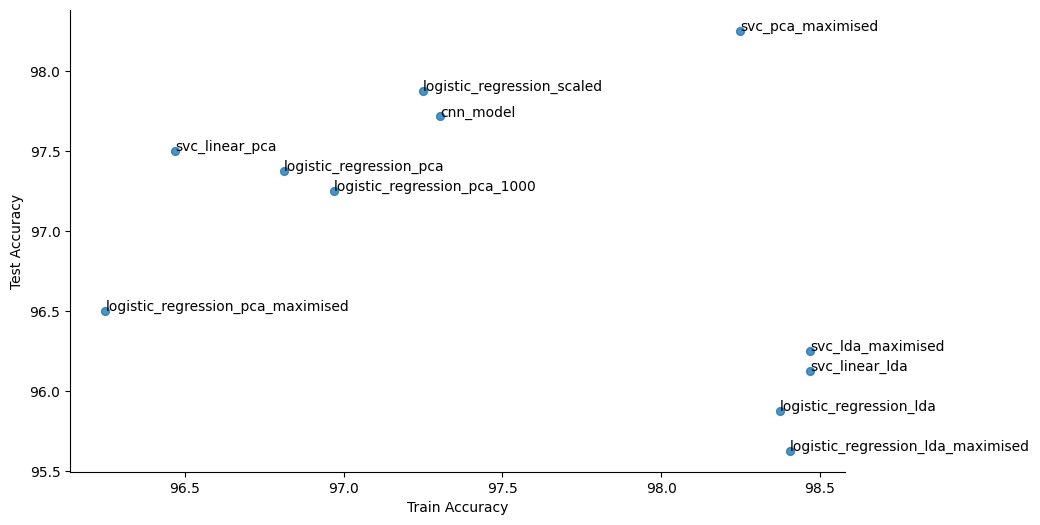

In [213]:
#Note*** The graphs provided made use of Google Collabs built in tools for generating graphs
# From dataframes, these graphs are NOT my own code and are simply visual evaluations of the
# data...

from matplotlib import pyplot as plt
Data.plot(kind='scatter', x='Train Accuracy', y='Test Accuracy', s=32, alpha=.8, figsize=(10, 6))
plt.gca().spines[['top', 'right',]].set_visible(False)

for i, row in Data.iterrows():
    plt.annotate(row['Model'], (row['Train Accuracy'], row['Test Accuracy']))
plt.show()

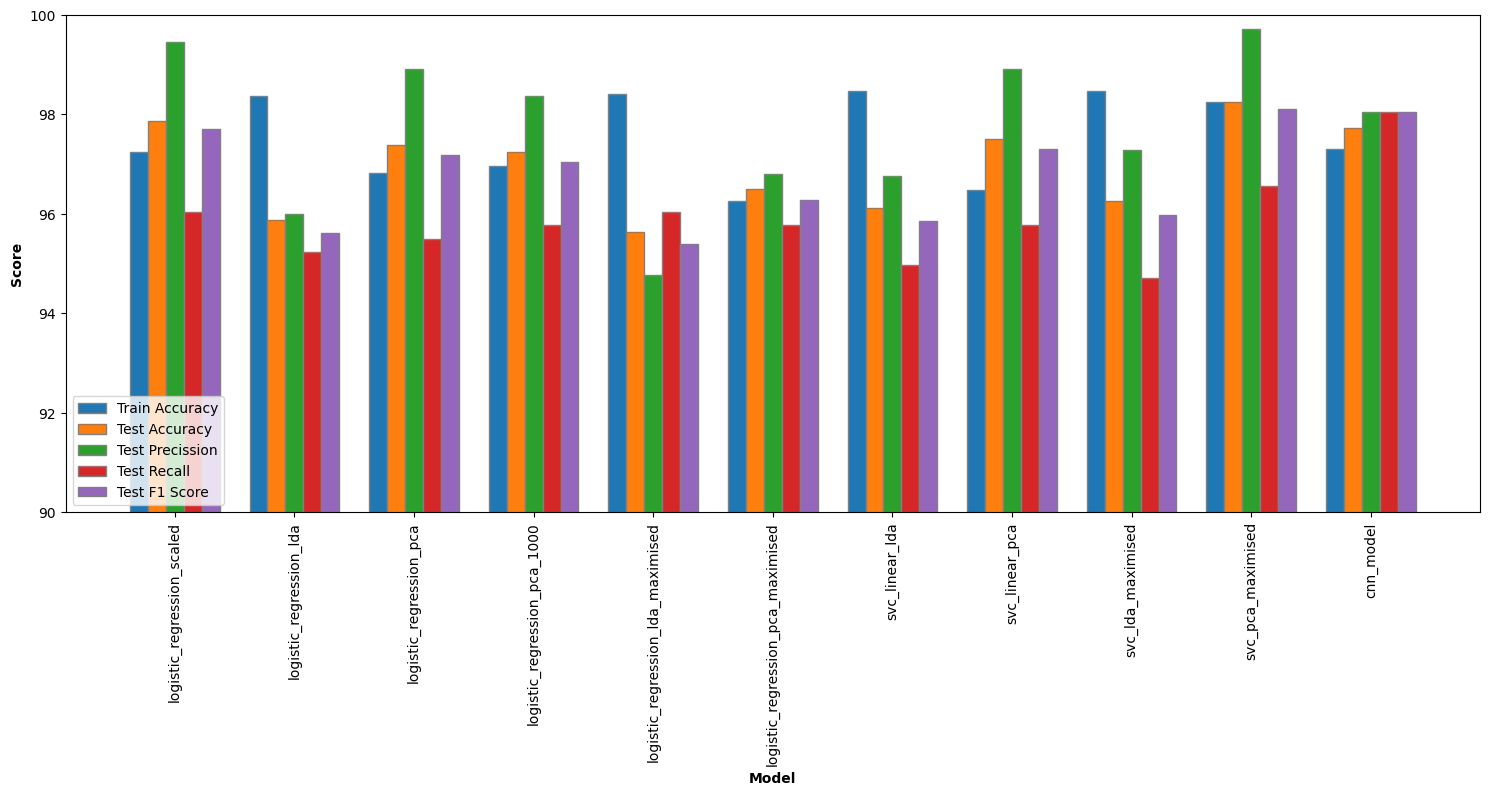

In [217]:
metrics = ['Train Accuracy', 'Test Accuracy', 'Test Precission', 'Test Recall', 'Test F1 Score']
bar_width = 0.15
r = np.arange(len(Data['Model']))

plt.figure(figsize=(15, 8))

for i, metric in enumerate(metrics):
    plt.bar(r + i * bar_width, Data[metric], color=f'C{i}', width=bar_width, edgecolor='grey', label=metric)

plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks(r + bar_width * (len(metrics) - 1) / 2, Data['Model'], rotation=90)
plt.legend(loc='lower left') # Moved legend to upper left
plt.tight_layout()
plt.ylim(90, 100) # Set y-axis limits
plt.show()